## Naive Bayes on Political Text

In this notebook we use Naive Bayes to explore and classify political data. See the `README.md` for full details. You can download the required DB from the shared dropbox or from blackboard

In [127]:
import sqlite3
import nltk
import random
import numpy as np
import re
from collections import Counter, defaultdict

# Imports added by me
import pandas as pd
from string import punctuation
from contractions import fix
from nltk.metrics.scores import precision, recall
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [10]:
convention_db = sqlite3.connect("2020_Conventions.db")
convention_cur = convention_db.cursor()

### Part 1: Exploratory Naive Bayes

We'll first build a NB model on the convention data itself, as a way to understand what words distinguish between the two parties. This is analogous to what we did in the "Comparing Groups" class work. First, pull in the text 
for each party and prepare it for use in Naive Bayes.  

In [25]:
# First figure out what table is named within convention_db to be able to query
convention_cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = convention_cur.fetchall()

# Print all table names within the db
for i in tables:
    print(i[0])

conventions


In [27]:
# Preview the data in the table conventions so I can properly query it in the next cell
convention_cur.execute("SELECT * FROM conventions LIMIT 5;")
rows = convention_cur.fetchall()

# Get & print column names
column_names = [i[0] for i in convention_cur.description]
print(column_names)

# Print each row
for j in rows:
    print(j)

['party', 'night', 'speaker', 'speaker_count', 'time', 'text', 'text_len', 'file']
('Democratic', 4, 'Unknown', 1, '00:00', 'Skip to content The Company Careers Press Freelancers Blog × Services Transcription Captions Foreign Subtitles Translation Freelancers About Contact Login « Return to Transcript Library home  Transcript Categories  All Transcripts 2020 Election Transcripts Classic Speech Transcripts Congressional Testimony & Hearing Transcripts Debate Transcripts Donald Trump Transcripts Entertainment Transcripts Financial Transcripts Interview Transcripts Political Transcripts Press Conference Transcripts Speech Transcripts Sports Transcripts Technology Transcripts Aug 21, 2020 2020 Democratic National Convention (DNC) Night 4 Transcript Rev  ›  Blog  ›  Transcripts  › 2020 Election Transcripts  ›  2020 Democratic National Convention (DNC) Night 4 Transcript Night 4 of the 2020 Democratic National Convention (DNC) on August 20. Read the full transcript of the event here. Transcr

In [24]:
# Load in all of conventions data prior to cleaning it out 
query1 = '''SELECT * FROM conventions;'''

conventions_raw_df = pd.read_sql_query(query1, convention_db)
conventions_raw_df.head()

,party,night,speaker,speaker_count,time,text,text_len,file
0,Democratic,4,Unknown,1,00:00,Skip to content The Company Careers Press Free...,127,www_rev_com_blog_transcripts2020-democratic-na...
1,Democratic,4,Speaker 1,1,00:33,I’m here by calling the full session of the 48...,41,www_rev_com_blog_transcripts2020-democratic-na...
2,Democratic,4,Speaker 2,1,00:59,"Every four years, we come together to reaffirm...",17,www_rev_com_blog_transcripts2020-democratic-na...
3,Democratic,4,Kerry Washington,1,01:07,We fight for a more perfect union because we a...,28,www_rev_com_blog_transcripts2020-democratic-na...
4,Democratic,4,Bernie Sanders,1,01:18,"We must come together to defeat Donald Trump, ...",22,www_rev_com_blog_transcripts2020-democratic-na...


In [64]:
# Clean & tokenize text field as instructed to for final convention_data list of lists in cell below

# Use functions from last assignment for cleaning & tokenization 
sw = nltk.corpus.stopwords.words("english")
punctuation=set(punctuation)

def remove_stop(tokens):
    # Return all tokens that are not in sw (stopwords)
    tokens = [word for word in tokens if word not in sw]
    return(tokens)
 
def remove_punctuation(text, punct_set=punctuation): 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text): 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    collapse_whitespace = re.compile(r'\s+')
    return(collapse_whitespace.split(text))

def fold_lowercase(text):
    # Cast to string first - in case anything is not already a string
    text = str(text)
    return text.lower()

def expand_contractions(text):
    # Expand out contractions using contractions package
    return fix(text)

def remove_empty_tokens(tokens):
    # Remove any empty tokens
    tokens = [word for word in tokens if word != '']
    return(tokens)

def prepare(text, 
            pipeline=[fold_lowercase, expand_contractions, remove_punctuation, tokenize, remove_stop, 
                      remove_empty_tokens]): 

    for transform in pipeline: 
        text = transform(text)
        
    return(text)

# Use pipeline to clean & tokenize "text" column
default_pipeline = [
    fold_lowercase,
    expand_contractions,
    remove_punctuation,
    tokenize,
    remove_stop,
    remove_empty_tokens
]

conventions_raw_df["tokens"] = conventions_raw_df["text"].apply(prepare,pipeline=default_pipeline)
conventions_raw_df.head()

,party,night,speaker,speaker_count,time,text,text_len,file,tokens
0,Democratic,4,Unknown,1,00:00,Skip to content The Company Careers Press Free...,127,www_rev_com_blog_transcripts2020-democratic-na...,"[skip, content, company, careers, press, freel..."
1,Democratic,4,Speaker 1,1,00:33,I’m here by calling the full session of the 48...,41,www_rev_com_blog_transcripts2020-democratic-na...,"[calling, full, session, 48th, quadrennial, na..."
2,Democratic,4,Speaker 2,1,00:59,"Every four years, we come together to reaffirm...",17,www_rev_com_blog_transcripts2020-democratic-na...,"[every, four, years, come, together, reaffirm,..."
3,Democratic,4,Kerry Washington,1,01:07,We fight for a more perfect union because we a...,28,www_rev_com_blog_transcripts2020-democratic-na...,"[fight, perfect, union, fighting, soul, countr..."
4,Democratic,4,Bernie Sanders,1,01:18,"We must come together to defeat Donald Trump, ...",22,www_rev_com_blog_transcripts2020-democratic-na...,"[must, come, together, defeat, donald, trump, ..."


In [75]:
# fill this list up with items that are themselves lists. The 
# first element in the sublist should be the cleaned and tokenized
# text in a single string. As part of your cleaning process,
# remove the stopwords from the text. The second element of the sublist
# should be the party. 
convention_data = conventions_raw_df[["tokens", "party"]].values.tolist()
print(convention_data[:5])

[[['skip', 'content', 'company', 'careers', 'press', 'freelancers', 'blog', '×', 'services', 'transcription', 'captions', 'foreign', 'subtitles', 'translation', 'freelancers', 'contact', 'login', '«', 'return', 'transcript', 'library', 'home', 'transcript', 'categories', 'transcripts', '2020', 'election', 'transcripts', 'classic', 'speech', 'transcripts', 'congressional', 'testimony', 'hearing', 'transcripts', 'debate', 'transcripts', 'donald', 'trump', 'transcripts', 'entertainment', 'transcripts', 'financial', 'transcripts', 'interview', 'transcripts', 'political', 'transcripts', 'press', 'conference', 'transcripts', 'speech', 'transcripts', 'sports', 'transcripts', 'technology', 'transcripts', 'aug', '21', '2020', '2020', 'democratic', 'national', 'convention', 'dnc', 'night', '4', 'transcript', 'rev', '›', 'blog', '›', 'transcripts', '›', '2020', 'election', 'transcripts', '›', '2020', 'democratic', 'national', 'convention', 'dnc', 'night', '4', 'transcript', 'night', '4', '2020', 

Let's look at some random entries and see if they look right. 

In [76]:
random.choices(convention_data,k=5)

[[['trump',
   'team',
   'gave',
   'us',
   'empathy',
   'never',
   'received',
   'obama',
   'administration',
   'obama',
   'administration',
   'said',
   'everything',
   'could',
   'trump',
   'administration',
   'let',
   'say',
   'kayla',
   'donald',
   'trump',
   'president',
   'kayla',
   'captured',
   'would',
   'today',
   'kayla',
   'hostage',
   'would',
   'go',
   'outside',
   'night',
   'look',
   'moon',
   'would',
   'look',
   'moon',
   'would',
   'promise',
   'would',
   'everything',
   'could',
   'get',
   'home',
   'see',
   'moon',
   'reminded',
   'promise',
   'could',
   'keep'],
  'Republican'],
 [['proudly',
   'displayed',
   'shortly',
   'later',
   'website',
   'displayed',
   'big',
   'letters',
   'make',
   'mistake',
   'give',
   'power',
   'joe',
   'biden',
   'radical',
   'left',
   'defund',
   'police',
   'departments',
   'across',
   'america',
   'pass',
   'federal',
   'legislation',
   'reduce',
   'law',
   

If that looks good, we now need to make our function to turn these into features. In my solution, I wanted to keep the number of features reasonable, so I only used words that occur at least `word_cutoff` times. Here's the code to test that if you want it. 

In [79]:
word_cutoff = 5

tokens = [token for token_list, party in convention_data for token in token_list]

word_dist = nltk.FreqDist(tokens)

feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")

With a word cutoff of 5, we have 2348 as features in the model.


In [86]:
def conv_features(text,fw) :
    """Given some text, this returns a dictionary holding the
       feature words.
       
       Args: 
            * text: a piece of text in a continuous string. Assumes
            text has been cleaned and case folded.
            * fw: the *feature words* that we're considering. A word 
            in `text` must be in fw in order to be returned. This 
            prevents us from considering very rarely occurring words.
        
       Returns: 
            A dictionary with the words in `text` that appear in `fw`. 
            Words are only counted once. 
            If `text` were "quick quick brown fox" and `fw` = {'quick','fox','jumps'},
            then this would return a dictionary of 
            {'quick' : True,
             'fox' :    True}
        
    """
    # Intitialize empty dict
    ret_dict = dict()
    
    # Split text on whitespace if not already list
    if type(text) != list:
        collapse_whitespace = re.compile(r'\s+')
        text = collapse_whitespace.split(text)
    
    # Iterate through tokens in text to append to dict
    for i in text:
        if (i in fw) & (i not in ret_dict.keys()):
            ret_dict[i] = True
    
    return(ret_dict)

In [84]:
# Test example provided
text = "quick quick brown fox"
fw = {'quick', 'fox', 'jumps'}
print(conv_features(text, fw))

{'quick': True, 'fox': True}


In [81]:
assert(len(feature_words)>0)
assert(conv_features("donald is the president",feature_words)==
       {'donald':True,'president':True})
assert(conv_features("some people in america are citizens",feature_words)==
                     {'people':True,'america':True,"citizens":True})

Now we'll build our feature set. Out of curiosity I did a train/test split to see how accurate the classifier was, but we don't strictly need to since this analysis is exploratory. 

In [87]:
featuresets = [(conv_features(text,feature_words), party) for (text, party) in convention_data]

In [88]:
random.seed(20220507)
random.shuffle(featuresets)

test_size = 500

In [89]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.506


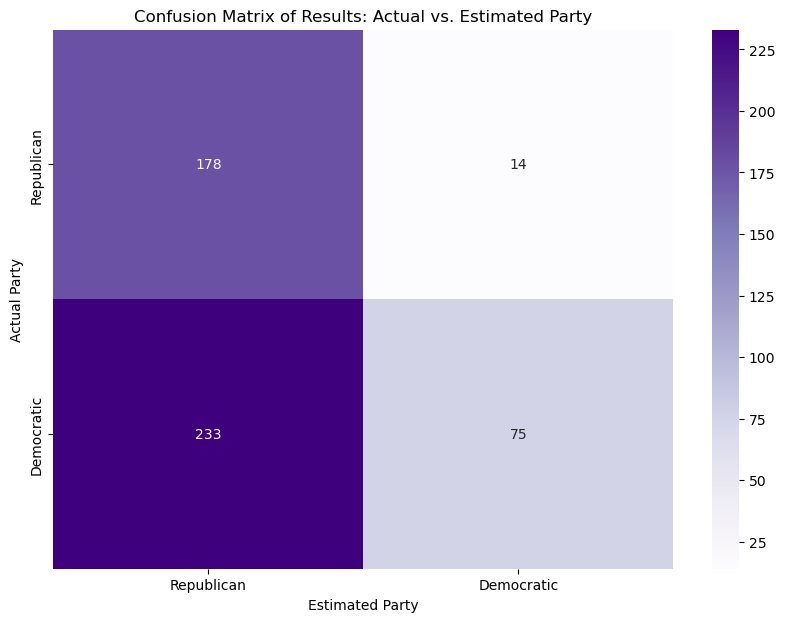

In [134]:
# Also get confusion matrix for
test_labels = [label for (text, label) in test_set]
test_pred = [classifier.classify(features) for (features, label) in test_set]

results_df = pd.DataFrame(confusion_matrix(test_labels, test_pred, labels=parties), 
                          index=parties, columns=parties)

plt.figure(figsize=(10, 7))
sns.heatmap(results_df, annot=True, fmt="d", cmap="Purples", xticklabels=parties, yticklabels=parties)
plt.xlabel("Estimated Party")
plt.ylabel("Actual Party")
plt.title("Confusion Matrix of Results: Actual vs. Estimated Party")
plt.show()

In [90]:
classifier.show_most_informative_features(25)

Most Informative Features
                   china = True           Republ : Democr =     25.8 : 1.0
                   votes = True           Democr : Republ =     23.8 : 1.0
             enforcement = True           Republ : Democr =     21.5 : 1.0
                 destroy = True           Republ : Democr =     19.2 : 1.0
                freedoms = True           Republ : Democr =     18.2 : 1.0
                 climate = True           Democr : Republ =     17.8 : 1.0
                supports = True           Republ : Democr =     17.1 : 1.0
                   crime = True           Republ : Democr =     16.1 : 1.0
                   media = True           Republ : Democr =     14.9 : 1.0
                 beliefs = True           Republ : Democr =     13.0 : 1.0
               countries = True           Republ : Democr =     13.0 : 1.0
                 defense = True           Republ : Democr =     13.0 : 1.0
                    isis = True           Republ : Democr =     13.0 : 1.0

Write a little prose here about what you see in the classifier. Anything odd or interesting?

### My Observations
Below are some of my observations regarding this classifier:

* The classifier itself is fairly poor, with an accuracy of 50.6%, meaning its predictions are correct only half the time. 
* The classifier overwhelmingly predicts speeches as Republican, even though there are actually more Democratic speeches in the corpus. Thus, if we call Republican the positive class, the sensitivity is actually fairly decent because 178/(178+14) = 92.71% of speeches with Republican speakers were correctly classified as Republican. However, the specificity is quite bad because 75/(75+233) = only 24.35% of speeches with Democratic speakers were correctly classified as Democratic.   
* Of the top 25 features, only 2 words ("votes" and "climate") are present more often in Democratic speeches than Republican speeches. All other 23 top features are words that make the classifier more likely to predict Republican rather than Democratic, which could be the reason why the sensitivity and specificity are as aforementioned. 


## Part 2: Classifying Congressional Tweets

In this part we apply the classifer we just built to a set of tweets by people running for congress
in 2018. These tweets are stored in the database `congressional_data.db`. That DB is funky, so I'll
give you the query I used to pull out the tweets. Note that this DB has some big tables and 
is unindexed, so the query takes a minute or two to run on my machine.

In [91]:
cong_db = sqlite3.connect("congressional_data.db")
cong_cur = cong_db.cursor()

In [94]:
query2 = '''
           SELECT DISTINCT 
                  cd.candidate, 
                  cd.party,
                  tw.tweet_text
           FROM candidate_data cd 
           INNER JOIN tweets tw ON cd.twitter_handle = tw.handle 
               AND cd.candidate == tw.candidate 
               AND cd.district == tw.district
           WHERE cd.party in ('Republican','Democratic') 
               AND tw.tweet_text NOT LIKE '%RT%';
        '''

tweets_raw_df = pd.read_sql_query(query2, cong_db)
tweets_raw_df.head()

,candidate,party,tweet_text
0,Mo Brooks,Republican,"b'""Brooks Joins Alabama Delegation in Voting A..."
1,Mo Brooks,Republican,"b'""Brooks: Senate Democrats Allowing President..."
2,Mo Brooks,Republican,"b'""NASA on the Square"" event this Sat. 11AM \x..."
3,Mo Brooks,Republican,"b'""The trouble with Socialism is that eventual..."
4,Mo Brooks,Republican,"b'""The trouble with socialism is eventually yo..."


In [96]:
# Now fill up tweet_data with sublists like we did on the convention speeches.
# Note that this may take a bit of time, since we have a lot of tweets.
tweets_raw_df["tokens"] = tweets_raw_df["tweet_text"].apply(prepare,pipeline=default_pipeline)
tweets_raw_df.head()

tweet_data = tweets_raw_df[["tokens", "party"]].values.tolist()
print(tweet_data[:5])

[[['bbrooks', 'joins', 'alabama', 'delegation', 'voting', 'flawed', 'funding', 'bill', 'httptco3cwjiwysnq'], 'Republican'], [['bbrooks', 'senate', 'democrats', 'allowing', 'president', 'give', 'americansxe2x80x99', 'jobs', 'illegals', 'securetheborder', 'httpstcomzteax8xs6'], 'Republican'], [['bnasa', 'square', 'event', 'sat', '11am', 'xe2x80x93', '4pm', 'stop', 'amp', 'hear', 'incredible', 'work', 'done', 'al05', 'downtownhsv', 'httptcor9zy8wmepa'], 'Republican'], [['bthe', 'trouble', 'socialism', 'eventually', 'run', 'peoples', 'money', 'margaret', 'thatcher', 'httpstcox97g7wzqwj'], 'Republican'], [['bthe', 'trouble', 'socialism', 'eventually', 'run', 'peoples', 'money', 'xe2x80x93', 'thatcher', 'sorely', 'missed', 'httptcoz8gbndquh8'], 'Republican']]


There are a lot of tweets here. Let's take a random sample and see how our classifer does. I'm guessing it won't be too great given the performance on the convention speeches...

In [97]:
random.seed(20201014)

tweet_data_sample = random.choices(tweet_data,k=10)

In [101]:
for tweet, party in tweet_data_sample :
    # Fill in the code that estimates the actual party
    featureset = conv_features(tweet, feature_words)
    estimated_party = classifier.classify(featureset)
    
    print(f"Here's our (cleaned) tweet: {tweet}")
    print(f"Actual party is {party} and our classifer says {estimated_party}.")
    print("")

Here's our (cleaned) tweet: ['bearlier', 'today', 'spoke', 'house', 'floor', 'protecting', 'health', 'care', 'women', 'praised', 'ppmarmonte', 'work', 'central', 'coast', 'httpstcowqgtrzt7vv']
Actual party is Democratic and our classifer says Republican.

Here's our (cleaned) tweet: ['bgo', 'tribe', 'rallytogether', 'httpstco0nxutfl9l5']
Actual party is Democratic and our classifer says Democratic.

Here's our (cleaned) tweet: ['bapparently', 'trump', 'thinks', 'easy', 'students', 'overwhelmed', 'crushing', 'burden', 'debt', 'pay', 'student', 'loans', 'trumpbudget', 'httpstcockyqo5t0qh']
Actual party is Democratic and our classifer says Republican.

Here's our (cleaned) tweet: ['bwexe2x80x99re', 'grateful', 'first', 'responders', 'rescue', 'personnel', 'firefighters', 'police', 'volunteers', 'working', 'tirelessly', 'keep', 'people', 'safe', 'provide', 'muchneeded', 'help', 'putting', 'lives', 'linennhttpstcoezpv0vmiz3']
Actual party is Republican and our classifer says Republican.

He

Now that we've looked at it some, let's score a bunch and see how we're doing.

In [104]:
# dictionary of counts by actual party and estimated party. 
# first key is actual, second is estimated
parties = ['Republican','Democratic']
results = defaultdict(lambda: defaultdict(int))

for p in parties :
    for p1 in parties :
        results[p][p1] = 0


num_to_score = 10000
random.shuffle(tweet_data)

for idx, tp in enumerate(tweet_data) :
    tweet, party = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
    featureset = conv_features(tweet, feature_words)
    # get the estimated party
    estimated_party = classifier.classify(featureset)
    
    results[party][estimated_party] += 1
    
    if idx > num_to_score : 
        break

In [105]:
results

defaultdict(<function __main__.<lambda>()>,
            {'Republican': defaultdict(int,
                         {'Republican': 3587, 'Democratic': 704}),
             'Democratic': defaultdict(int,
                         {'Republican': 4721, 'Democratic': 990})})

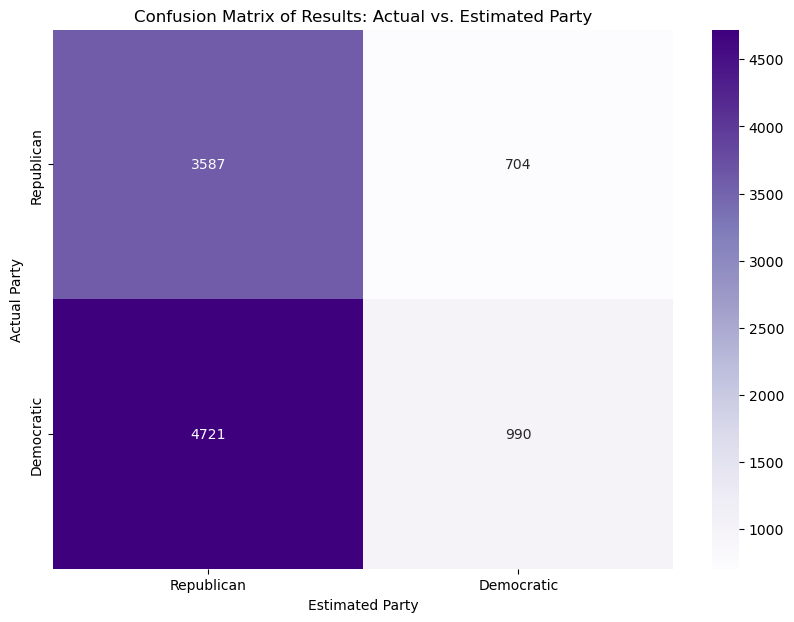

In [114]:
# Turn results into confusion matrix for ease of visualizing
# Create the confusion matrix
confusion_matrix = pd.DataFrame(results).T

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=parties, yticklabels=parties)
plt.xlabel("Estimated Party")
plt.ylabel("Actual Party")
plt.title("Confusion Matrix of Results: Actual vs. Estimated Party")
plt.show()

In [126]:
# Get metrics for more accurate reflections below as well
results_df = pd.DataFrame(results)
TP = results_df.loc['Republican', 'Republican']
FP = results_df.loc['Republican', 'Democratic']
FN = results_df.loc['Democratic', 'Republican']
TN = results_df.loc['Democratic', 'Democratic']

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Accuracy: " + str(accuracy))
print("Sensitivity: " + str(sensitivity))
print("Specificity: " + str(specificity))

Accuracy: 0.45760847830433915
Sensitivity: 0.8359356793288277
Specificity: 0.17334967606373664


### Reflections

Similarly to the results for the convention speeches, the classifier overwhelmingly classifies tweets as by Republican authors, even though the sample actually has more tweets by Democratic authors than Republican ones. The overall classifier has an accuracy of 45.76%, but that's not how accurate it is at predicting tweets for each party. If we consider Republican our positive class and Democratic our negative class, the sensitivity is comparitively high (0.8359) because the classifier correctly identifies tweets from Republican authors as actually from them 83.59% of the time. However, as we earlier discussed, the classifier overwhelmingly classifies tweets as Republican (despite the true author's party), so the specificity is very low. Tweets from Democratic authors are correctly identified as Democratic only 17.33% of the time, which is very low. Thus, this classifier performs quite poorly on the tweet data. Future improvements could include actually training on the tweet data rather than using our classifier trained on convention speech data, improving our text cleaning/tokenization, sourcing more tweets, ensuring there's a sufficient amount of tweets per candidate, etc. 